Make all the imports

In [4]:
import pandas_datareader as web
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Get all the stock symbols and dowload all the closing prices and the volumes traded from Yahoo Finance

In [5]:
stocks = []
f = open('symbols.txt', 'r')
for line in f:
    stocks.append(line.strip())
f.close()

yf.download(stocks, start='2000-01-01', end='2024-08-02')['Adj Close'].to_csv('prices.csv')
yf.download(stocks, start='2000-01-01', end='2024-08-02')['Volume'].to_csv('volume.csv')
#web.DataReader(stocks, 'yahoo', start='2000-1-1', end='2019-12-31')['Adj Close'].to_csv('prices.csv')
#web.DataReader(stocks, 'yahoo', start='2000-1-1', end='2019-12-31')['Volume'].to_csv('volume.csv')

[*********************100%%**********************]  503 of 503 completed

48 Failed downloads:
['DISCA', 'NLSN', 'ATVI', 'FRC', 'PEAK', 'PXD', 'WCG', 'DISH', 'BLL', 'INFO', 'ANTM', 'DRE', 'HFC', 'DISCK', 'FB', 'COG', 'ADS', 'FLIR', 'ABMD', 'VIAC', 'WLTW', 'NLOK', 'ETFC', 'ARNC', 'XLNX', 'UTX', 'XEC', 'PKI', 'KSU', 'VAR', 'FBHS', 'ABC', 'TWTR', 'FLT', 'RE', 'CERN', 'MYL', 'NBL', 'ALXN', 'CTL', 'RTN', 'TIF', 'CTXS', 'AGN', 'MXIM', 'PBCT', 'CXO']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
['SIVB']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  503 of 503 completed

48 Failed downloads:
['NLSN', 'ATVI', 'DISCA', 'PEAK', 'FRC', 'PXD', 'WCG', 'DISH', 'BLL', 'INFO', 'ANTM', 'DRE', 'HFC', 'DISCK', 'FB', 'COG', 'ADS', 'FLIR', 'ABMD', 'WLTW', 'VIAC', 'ETFC', 'NLOK', 'ARNC', 'XLNX', 'UTX', 'XEC', 'PKI', 'KSU', 'VAR', 'FBHS', 'ABC', 'TWTR', 'FLT', 'RE', 'CERN', 'NBL', 'MYL', 'ALXN

Create dataframes containing the log changes in volumes and log changes in price

In [124]:
prices = pd.read_csv('prices.csv', index_col = 'Date', parse_dates=True)
volumechanges = pd.read_csv('volume.csv', index_col = 'Date', parse_dates=True)
volumechanges = np.log(volumechanges / volumechanges.shift(1))
pricechanges = pd.read_csv('prices.csv', index_col = 'Date', parse_dates=True)
twoDayChange = np.log(pricechanges / pricechanges.shift(2))
pricechanges = np.log(pricechanges / pricechanges.shift(1))

Set the start and end date of the simulation and all the lists/dictionaries required for the simulation

In [125]:
today = dt.date(2023,8,2)
simend = dt.date(2024,8,2)
tickers = []
transactionid = 0
money = 1000000
portfolio = {}
activelog = []
transactionlog = []

Get the current prices of all stocks.

In [126]:
def getprice(date, ticker):
    global prices
    return prices.loc[np.datetime64(date)][ticker]

Makes two dictionaries of all the transactoins we do:
- The first dictionary is all of our active positions
- The second dictionary contains all transactions that have been made.


In [127]:
def transaction(trans_id, ticker, amount, price, trans_type, info):
    global transactionid
    if trans_type == 'buy':
        transactionid += 1
        data = {'transaction ID':transactionid, 'ticker':ticker, 'amount':amount, 'price':price, 'type':trans_type, 'info':info}
        activelog.append(data)
    elif trans_type == 'sell':
        data = {'transaction ID':trans_id, 'ticker':ticker, 'amount':amount, 'price':price, 'type':trans_type, 'info':info}
    transactionlog.append(data)

This function buys all of the stocks in our interest list with the allocated money and then calls the transaction function to record the transaction

In [128]:
def buy(interestlst, allocated_money):
    global money, portfolio
    for item in interestlst:
        price = getprice(today, item)
        if not np.isnan(price):
            quantity = math.floor(allocated_money/price)
            money -= quantity*price
            portfolio[item] += quantity
            transaction(0, item, quantity, price, 'buy', "")

Sells all the stocks that meet the conditions of our strategy. The transaction() function is called to record the transaction. All the sold stocks are removed from our active log.

In [129]:
def sell():
    global money, portfolio, prices, today
    short_window = 50
    long_window = 150
    short_ma = prices.rolling(window=short_window).mean()
    long_ma = prices.rolling(window=long_window).mean()
    itemstoremove = []
   
    for i in range(len(activelog)):
        log = activelog[i]
        ticker = log['ticker']
        original_price = log['price']
        tickprice = getprice(today, ticker)
        if np.isnan(tickprice):
            continue  
        try:
            short_ma_value = short_ma.loc[today, ticker]
            long_ma_value = long_ma.loc[today, ticker]
        except KeyError:
            continue 
        if (short_ma_value < long_ma_value) or (0.98 * original_price >= tickprice) :
            if portfolio[ticker] > 0:  
                money += log["amount"] * tickprice
                portfolio[ticker] -= log["amount"]
                transaction(log["transaction ID"], ticker, log["amount"], tickprice, "sell")
                itemstoremove.append(i)
        else:
            if 1.04 * original_price <= tickprice:
                money += log["amount"] * tickprice
                portfolio[ticker] -= log["amount"]
                transaction(log["transaction ID"], ticker, log["amount"], tickprice, "sell")
                itemstoremove.append(i)
    itemstoremove.reverse()
    for elem in itemstoremove:
        activelog.remove(activelog[elem])


Creates a list of all the stocks that are worth buying according to our strategy

In [130]:
def simulation():
    global today, prices, money, portfolio, pricechanges
    short_window = 50
    long_window = 150
    short_ma = prices.rolling(window=short_window).mean()
    long_ma = prices.rolling(window=long_window).mean()
    tickers = portfolio.keys()
    interestlst = []
    start_date = today - dt.timedelta(days=7)

    for ticker in tickers:
        short_ma_value = short_ma[ticker].loc[np.datetime64(today)]
        long_ma_value = long_ma[ticker].loc[np.datetime64(today)]
        if np.isnan(short_ma_value) or np.isnan(long_ma_value):
            continue
        if short_ma_value > long_ma_value:
            if portfolio[ticker] == 0:
                interestlst.append(ticker)
   
    meanprice = pricechanges.loc[start_date:today].mean().sort_values()
    interestlst2 = meanprice[(meanprice > 0.00900)].index.tolist()
    interestlst.extend(interestlst2)

    if len(interestlst) > 0:
        #moneyToAllocate = 500000/len(interestlst)
        moneyToAllocate = currentvalue()/(2*len(interestlst))
        buy(interestlst[0:round(len(interestlst)/2)], moneyToAllocate)

**getindices():** This function gets all the stock symbols and stores them.

In [131]:
def getindices():
    global tickers
    f = open("symbols.txt", "r")
    for line in f:
        tickers.append(line.strip())
    f.close()

**tradingday():** This finction checks if today is a trading day and returns a boolean.

In [132]:
def tradingday():
    global prices, today
    return np.datetime64(today) in list(prices.index.values)

**currentvalue():** This function calculates the total account value (money + the portfolio value).

In [133]:
def currentvalue():
    global money, portfolio, today, prices
    value = money
    for ticker in tickers:
        tickprice = getprice(today, ticker)
        if not np.isnan(tickprice):
            value += portfolio[ticker]*tickprice
    return int(value*100)/100

The main function resets the protfolio and iterates through all the dates, calling the simulation function in order to buy and sell according to our strategy.

In [134]:
def main():
    global today, money, portfolio
    getindices()
    for ticker in tickers:
        portfolio[ticker] = 0
    dates = []
    accountvalue = []
    while today < simend:
        while not tradingday():
            today += dt.timedelta(days=1)
        simulation()
        currentpvalue = currentvalue()
        today += dt.timedelta(days=1)
        accountvalue.append(currentpvalue)
        dates.append(today)
    plt.plot(dates, accountvalue)
    plt.xlabel("Date")
    plt.ylabel("Account Value")
    plt.show()

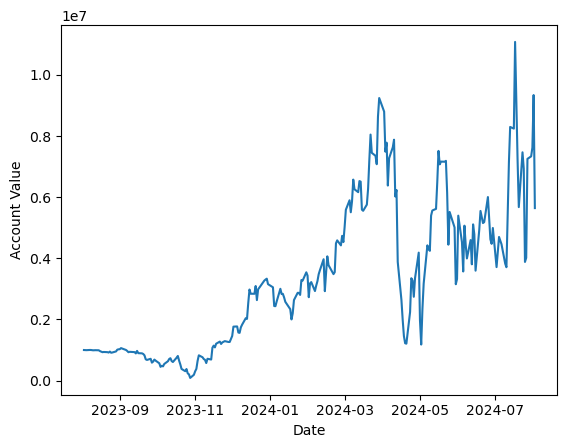

In [135]:
main()